In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import xarray as xr

import neuro_op as nop

In [2]:
nop.plot_setup()
cmap = "inferno"

In [3]:
def get_name(N_nodes, nn, sd_llf):
    return str(
        "../testing/@MA1-FirstBuilder/output/"
        + "out"
        + "-N"
        + str(N_nodes)
        + "-nn"
        + str(nn)
        + "-sd_llf"
        + str(sd_llf)
        + ".h5"
    )


def get_mu(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["mu_nodes"]


def get_kld(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["kl_divs"]

In [4]:
# Parameter ranges used for simulations
N_arr = [1, 2, 150]
nn_arr = np.round(np.arange(4, 21, 4), 0)
sd_llf_arr = np.round(np.arange(0.5, 5.1, 0.5), 1)

# Time span and xarray preparation
t_arr = np.arange(0, len(get_kld(N_arr[-1], nn_arr[-1], sd_llf_arr[-1])), 1)
tmp_arr = np.zeros((len(N_arr), len(nn_arr), len(sd_llf_arr), len(t_arr), max(N_arr)))

In [5]:
# Initialize xarray Dataset
ds = xr.Dataset(
    {
        "mu": (("N", "nn", "sd_llf", "time", "node"), tmp_arr),
        "kld": (("N", "nn", "sd_llf", "time", "node"), tmp_arr),
    },
    coords={
        "N": N_arr,
        "nn": nn_arr,
        "sd_llf": sd_llf_arr,
        "time": np.arange(101),
        "node": np.arange(max(N_arr)),
    },
)

# Populate the Dataset
for i, N in enumerate(N_arr):
    for j, nn in enumerate(nn_arr):
        for k, sd_llf in enumerate(sd_llf_arr):
            mu_result = get_mu(N, nn, sd_llf)
            kld_result = get_kld(N, nn, sd_llf)
            ds["mu"][i, j, k, :, :N] = mu_result
            ds["kld"][i, j, k, :, :N] = kld_result

# df = ds.to_dataframe()
ds

<xarray.Dataset> Size: 36MB
Dimensions:  (N: 3, nn: 5, sd_llf: 10, time: 101, node: 150)
Coordinates:
  * N        (N) int64 24B 1 2 150
  * nn       (nn) int64 40B 4 8 12 16 20
  * sd_llf   (sd_llf) float64 80B 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * time     (time) int64 808B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * node     (node) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    mu       (N, nn, sd_llf, time, node) float64 18MB 1.856 0.0 ... 1.183 1.181
    kld      (N, nn, sd_llf, time, node) float64 18MB 1.856 0.0 ... 1.183 1.181

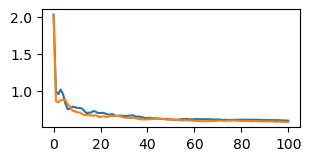

In [6]:
foo = ds.sel(N=2, nn=12, sd_llf=2.5, node=range(2))["kld"]
foo.mean(axis=1)
plt.plot(foo)

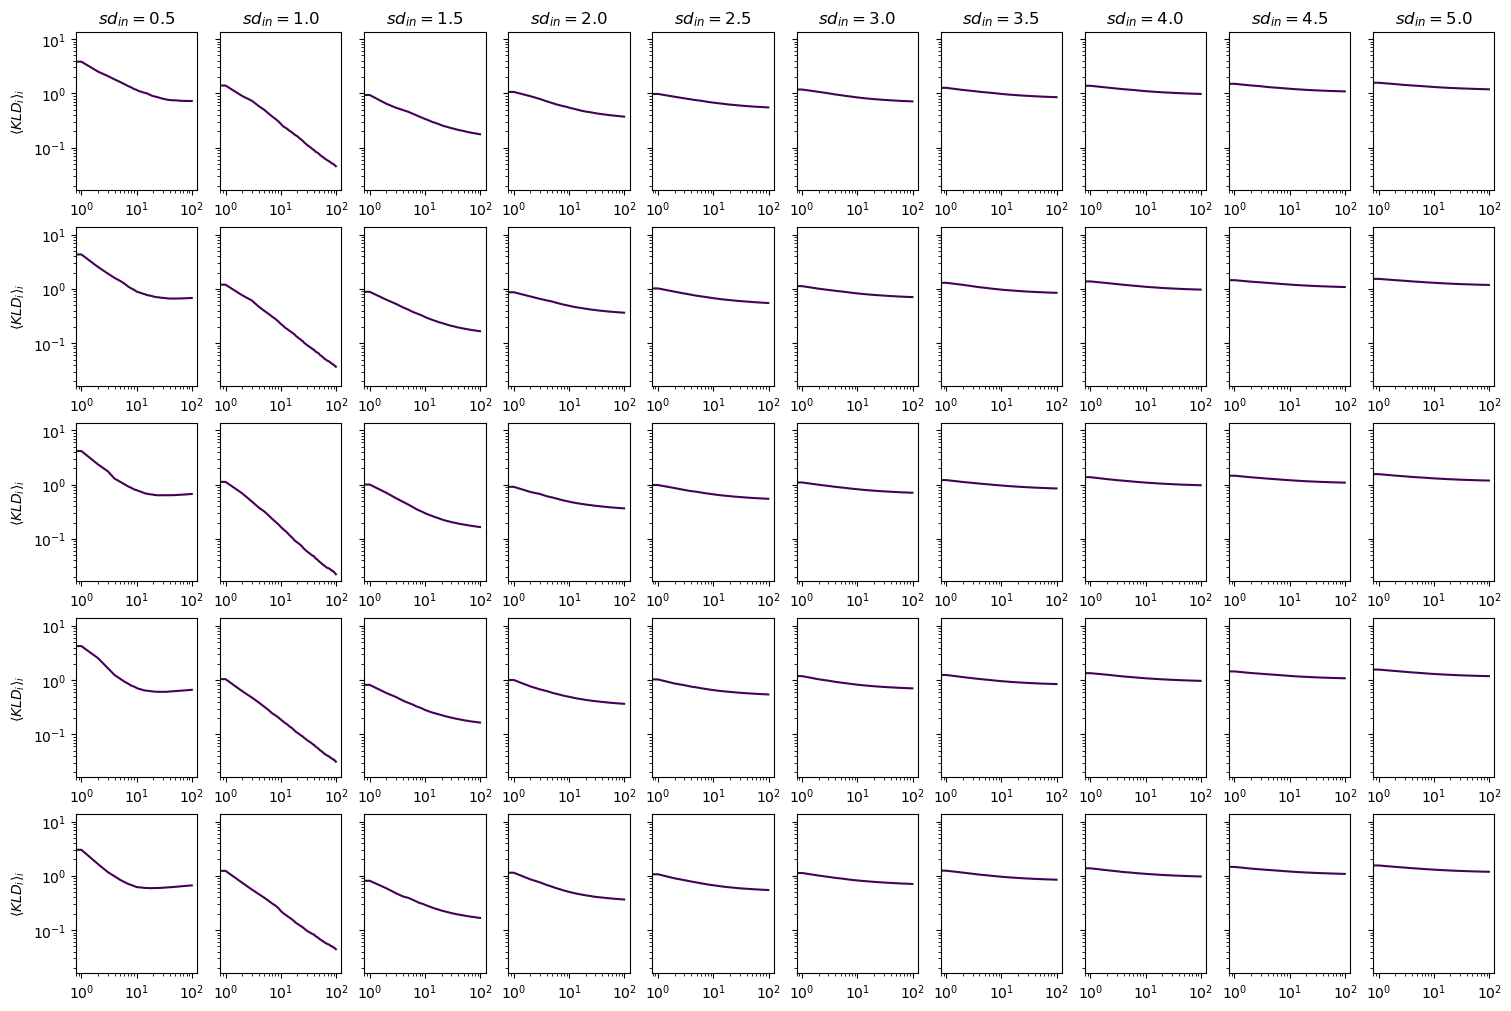

In [7]:
N_tmp = 150
x = len(nn_arr)
y = len(sd_llf_arr)
fig, ax = plt.subplots(x, y, figsize=(3 * x, 1 * y), sharey=True)
for i, nn in enumerate(nn_arr):
    for j, sd_llf in enumerate(sd_llf_arr):
        if i == 0:
            ax[i, j].set_title("$sd_{in} = $" + str(sd_llf))
        if j == 0:
            ax[i, j].set_ylabel("$\langle KLD_i \\rangle_i$")
        if j == y:
            ax[i, j].set_ylabel("$t$")
        ax[i, j].set_prop_cycle(color=nop.get_colorcycle(N_tmp))
        ax[i, j].plot(
            np.mean(
                ds.sel(
                    N=N_tmp, nn=nn, sd_llf=sd_llf, node=range(N_tmp), time=t_arr[1:]
                )["kld"],
                axis=1,
            )
        )
        ax[i, j].loglog()

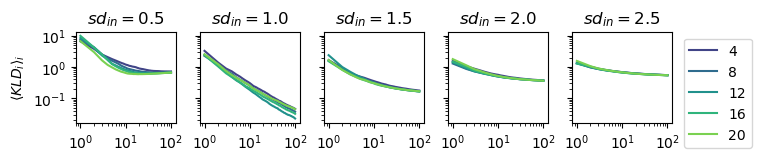

In [26]:
N_tmp = 150
sd_llf_arr = ds["sd_llf"].values[0:5]
nn_arr = ds["nn"].values
x = len(sd_llf_arr)
y = 1
fig, ax = plt.subplots(y, x, figsize=(1.5 * x, 1.5 * y), sharex=True, sharey=True)
for i, sd_llf in enumerate(sd_llf_arr):
    ax[i].set_prop_cycle(color=nop.get_colorcycle(len(nn_arr)))
    ds_tmp = np.mean(
        ds.sel(N=N_tmp, sd_llf=sd_llf, node=range(N_tmp), time=t_arr[1:])["kld"], axis=2
    )
    for j in nn_arr:
        ax[i].plot(ds_tmp.time, ds_tmp.sel(nn=j), label=str(j))
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
    ax[i].set_title("$sd_{in} = $" + str(sd_llf))
    if i == 0:
        ax[i].set_ylabel("$\langle KLD_i \\rangle_i$")
    if i == len(sd_llf_arr) - 1:
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

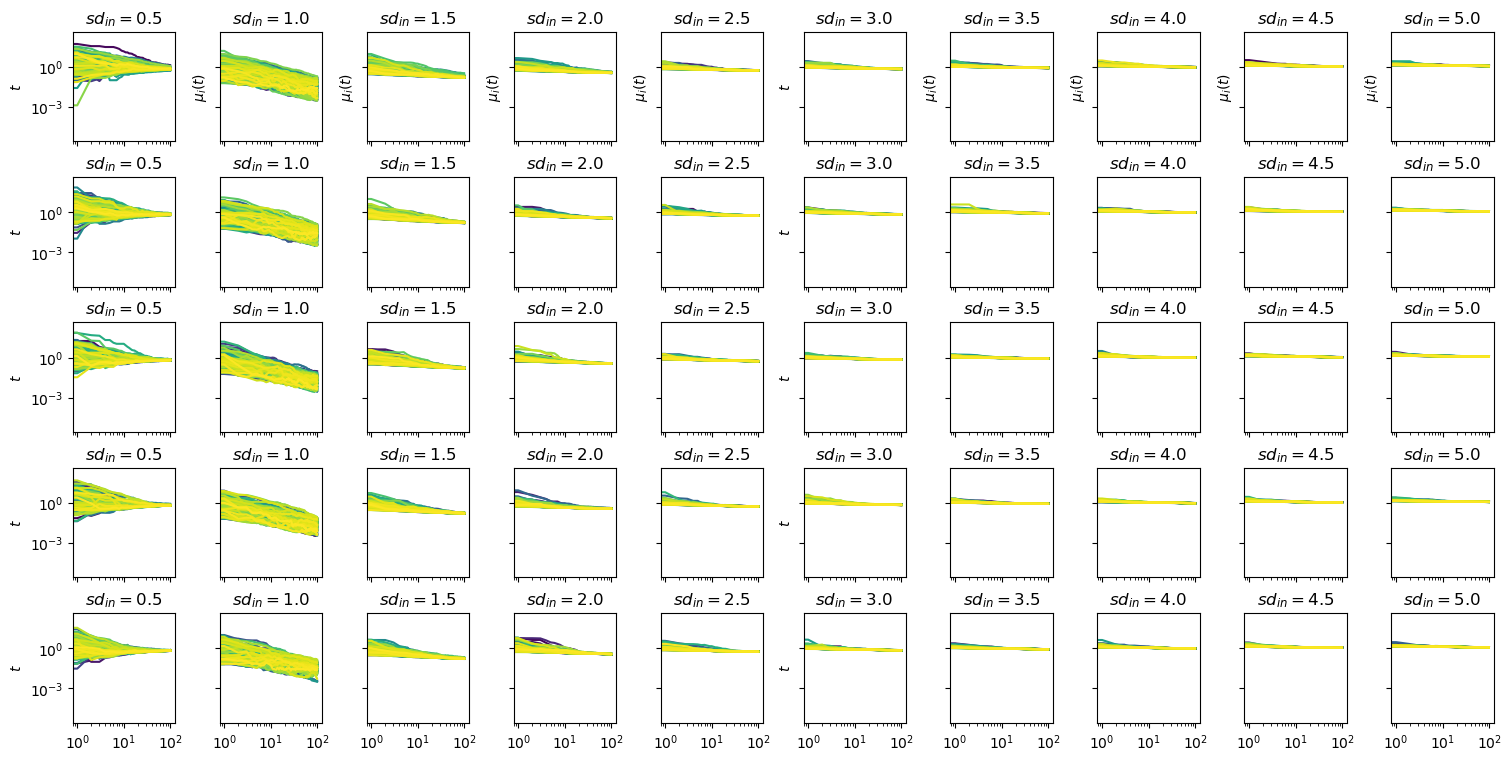

In [29]:
# Having dealt with KLD, let's now look at the mu values over time
N_tmp = 150
sd_llf_arr = ds["sd_llf"].values
nn_arr = ds["nn"].values
x = len(sd_llf_arr)
y = len(nn_arr)
fig, ax = plt.subplots(y, x, figsize=(1.5 * x, 1.5 * y), sharex=True, sharey=True)
for i, nn in enumerate(nn_arr):
    for j, sd_llf in enumerate(sd_llf_arr):
        ax[i, j].set_prop_cycle(color=nop.get_colorcycle(N_tmp))
        ax[i, j].plot(
            ds.sel(N=N_tmp, nn=nn, sd_llf=sd_llf, node=range(N_tmp), time=t_arr[1:])[
                "mu"
            ],
        )
        # ax[i, j].set_xscale("log")
        # ax[i, j].set_yscale("log")
        ax[i, j].set_title("$sd_{in} = $" + str(sd_llf))
        if i == 0:
            ax[i, j].set_ylabel("$\mu_i(t)$")
        if j == 0:
            ax[i, j].set_ylabel("$t$")
        if j == y:
            ax[i, j].set_ylabel("$t$")